# **Question 1**
(a) Take the image heart.jpg and find a threshold to pull out the two heart
chambers. Please give me the threshold and results.

Threshold Value :  183


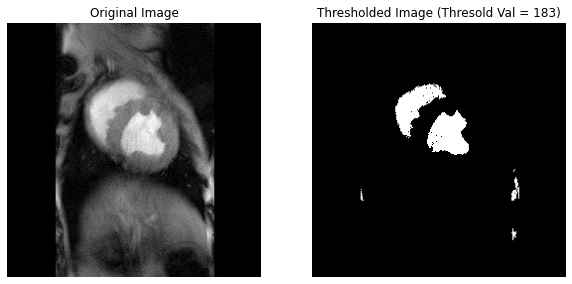

In [519]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('heart.jpg', cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding
# filtered_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2)

threshold = 183
_, filtered_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10,20))

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(filtered_img, 'gray')
plt.axis('off')
plt.title('Thresholded Image (Thresold Val = ' + str(threshold) + ')')

print('Threshold Value : ', threshold)

The chambers have been separated using the threshold value of **183** although there is a bit of noise as well.

(b) Take the image brain.tech.jpg and find a threshold to pull out the tumor. Please give me the threshold and results.

In this case, the tumor region is similar in intensity to other regions as well, therefore, it was not feasible to just segment the tumor part. I tried three different methods for thresholding.  

**Method 1** - Choose a threshold value (like the first case).

Threshold Value :  150


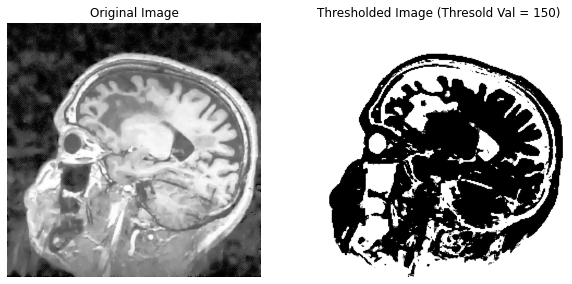

In [38]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('brain.tech_crop.jpg', cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding
# filtered_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2)

threshold = 150
_, filtered_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
filtered_img = 255 - filtered_img

plt.figure(figsize=(10,20))

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(filtered_img, 'gray')
plt.axis('off')
plt.title('Thresholded Image (Thresold Val = ' + str(threshold) + ')')

print('Threshold Value : ', threshold)

In this case, I used threshold of **150** and many other regions got segmented as well. So, instead of using a single threshold, I tried using 2 threshold values and segment only if the intensity values lie between these 2 threshold.  

**Method 2** - Using 2 threshold values - threshold1 and threshold2



```
Image[Image > threshold1 and Image < threshold2] = 255
Image[Image <= threshold1 or Image >= threshold2] = 0
```



Text(0.5, 1.0, 'Thresholded Image (Thresold between 120 and 150')

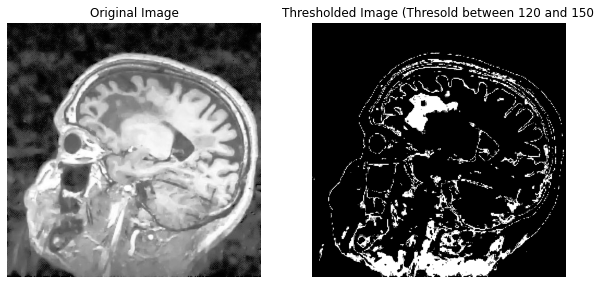

In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('brain.tech_crop.jpg', cv2.IMREAD_GRAYSCALE)

filtered_img = 255 * np.ones((img.shape[0], img.shape[1]))

lower_limit = 120
upper_limit = 150

for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i][j] > lower_limit and img[i][j] < upper_limit:
      filtered_img[i][j] = 255
    else:
      filtered_img[i][j] = 0

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(filtered_img, 'gray')
plt.axis('off')
plt.title('Thresholded Image (Thresold between ' + str(lower_limit) + ' and ' + str(upper_limit))

This method is better than the first one but also segmenting few other regions. So, I finally decided to create a rectangular window around the tumor manually and then doing thresholding of that rectangular region only.

**Method 3** - Create a rectangular window around tumor manually and then do the thresholding.

Threshold Value :  170


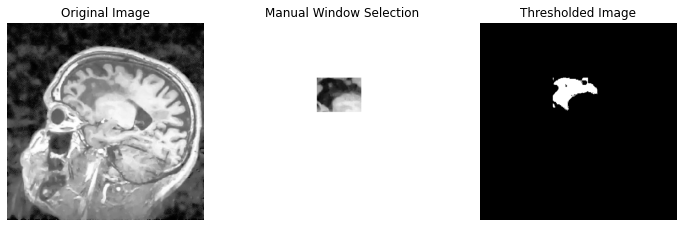

In [49]:
import cv2
import matplotlib.pyplot as plt
import copy

img = cv2.imread('brain.tech_crop.jpg', cv2.IMREAD_GRAYSCALE)
img_cpy1 = copy.deepcopy(img)
img_cpy2 = copy.deepcopy(img)


point = [(180,135),(290,220)]
img_cropped = img_cpy1[point[0][1]:point[1][1], point[0][0]:point[1][0]]
img_cpy2[:,:] = 255
img_cpy2[point[0][1]:point[1][1], point[0][0]:point[1][0]] = img_cropped

threshold = 170
_, filtered_img = cv2.threshold(img_cpy2, threshold, 255, cv2.THRESH_BINARY)
filtered_img = 255 - filtered_img

plt.figure(figsize=(12,36))

plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(img_cpy2, 'gray')
plt.axis('off')
plt.title('Manual Window Selection')

plt.subplot(1,3,3)
plt.imshow(filtered_img, 'gray')
plt.axis('off')
plt.title('Thresholded Image')

print('Threshold Value : ', threshold)

I don't think this is a good method as it required creating a window manually.



---



---



---



# **Question 2**
Look up the watershed segmentation method, explain it, and apply to the test images heart.jpg and brain.tech.jpg.

### **Watershed Segmentation**
Watershed segmentation is a powerful technique to segment an image into distinct regions (or objects). The image is viewed as a topographical map, with intensity values representing the height (high values correspond to peaks and low correspond to valleys).  

There are different algorithms to compute the watershed. We define the regions in the image using the basins and ridges in the topographical map.  

The core concept of the algorithm is to start flooding the image from it's minima and keep on flooding it until it starts to reach different catchment basins. These catchment basins are then used to define the segments in the image. 

The algorithm works with the following steps -


*   Get the gradient of the image using some edge detection method and perform thresholding to get a binary image
*   Perform a morphological operning operation on this binary image to remove small objects and fill the small gaps
*   Compute the local minima of the image so that each local minima will have a unique value assigned to it
*   Mark these minima regions as markers in a marker image. This marker image is initialized to 0 everywhere except at regional minima, where it is given the value define in above step.
*   Using this marker image, compute the watershed transform (assign labels to pixels based on their minima regions)
*   Merge regions belonging to same object.







In [502]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def WatershedSegmentation(img, threshold_val, image_title):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(20,48))

    plt.subplot(1,4,1)
    plt.imshow(gray, 'gray')
    plt.axis('off')
    plt.title('Original Image ' + image_title)

    # Thresholding
    ret, thresh = cv2.threshold(gray,threshold_val,255,cv2.THRESH_BINARY)

    # Noise removal using morphological operation
    kernel = np.ones((3,3),np.uint8)
    clean_img = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 1)

    # Background area
    bg_region = cv2.dilate(clean_img, kernel, iterations=3)

    # Distance transformation for foreground area
    dist_transform = cv2.distanceTransform(clean_img, cv2.DIST_L2, 3)
    ret, fg_region = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

    plt.subplot(1,4,2)
    plt.imshow(dist_transform, 'gray')
    plt.axis('off')
    plt.title('Distance Transform')
    # plt.show()

    fg_region = np.uint8(fg_region)
    remaining_region = cv2.subtract(bg_region,fg_region)

    ret, markers = cv2.connectedComponents(fg_region)

    markers = markers+1
    markers[remaining_region==255] = 0

    markers = cv2.watershed(img,markers)

    plt.subplot(1,4,3)
    plt.imshow(markers, 'gray')
    plt.axis('off')
    plt.title('Markers')
    # plt.show()

    img[markers == -1] = [0,0,255]

    plt.subplot(1,4,4)
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.title('Segmented Regions')
    # plt.suptitle('Heart Image')
    plt.show()

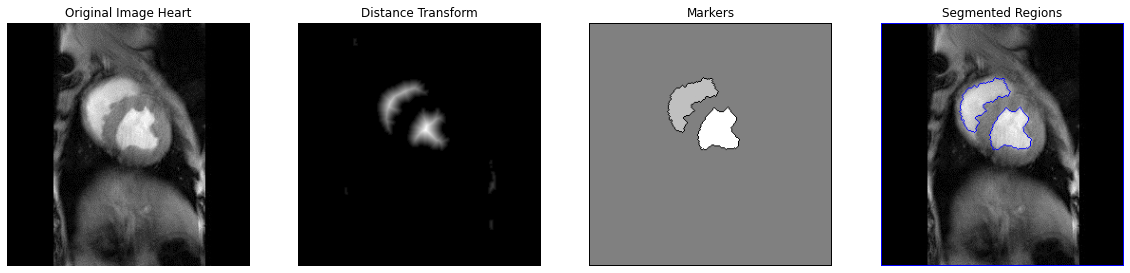

In [503]:
################## Heart Image ############################
img = cv2.imread('heart.jpg')
WatershedSegmentation(img, 150, 'Heart')

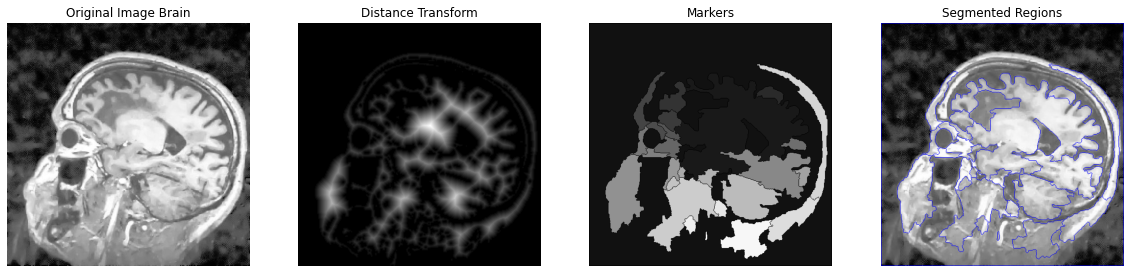

In [512]:
################## Heart Image ############################
img = cv2.imread('brain.tech_crop.jpg')
WatershedSegmentation(img, 140, 'Brain')

Due to the same reasons as mentioned in the threshold question (1b), we can not segment the tumor from the image using watershed segmentation.



---



---



---



# **Question 3**
Apply the Laplacian of Gaussian (LoG) operator to find the edges in heart.jpg
and brain.tech.jpg. Try several different values of the variance sigma. For example, sigma=1, 10, 100, 1000.

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def LoG(image, sigma, threshold_val):
  gaussian_blurred_img = cv2.GaussianBlur(image, (3,3), sigma)

  # Laplacian of the Gaussian
  laplacian_of_gaussian = cv2.Laplacian(gaussian_blurred_img, cv2.CV_64F)

  _, final_edges = cv2.threshold(laplacian_of_gaussian, threshold_val, 255, cv2.THRESH_BINARY)

  return laplacian_of_gaussian, final_edges

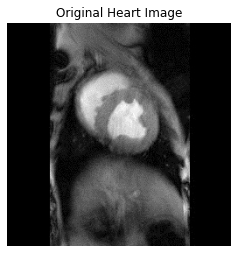

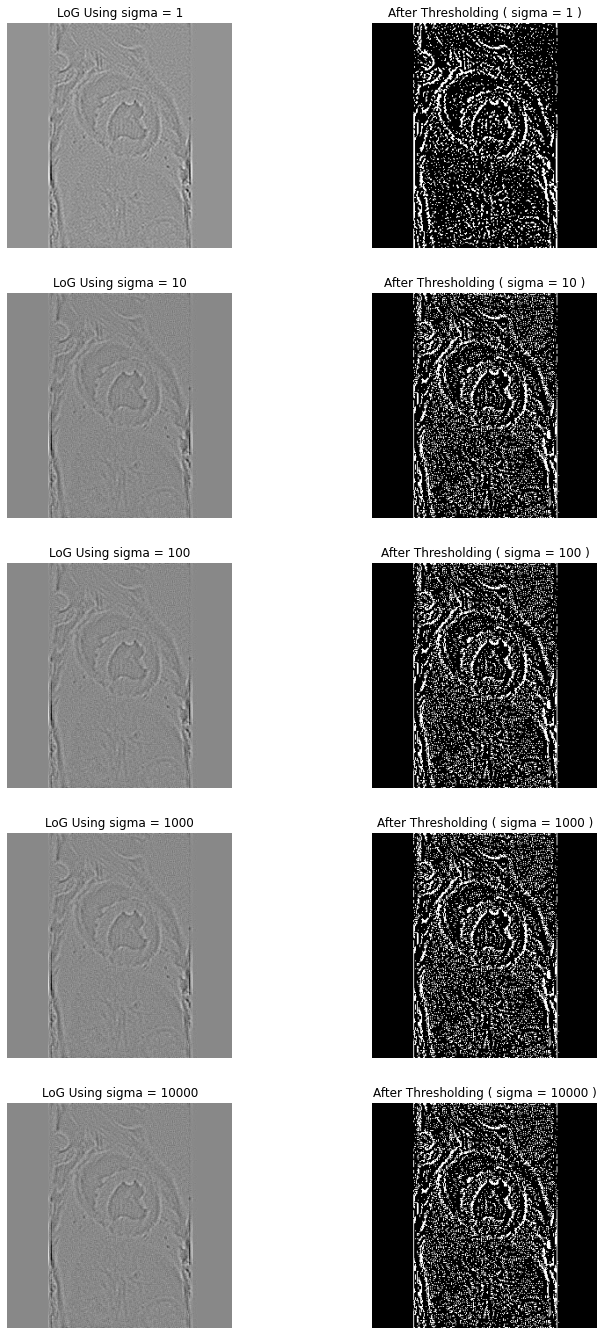

In [58]:
############################### Heart Image #################################
plt.figure(figsize=(4,6))
img = cv2.imread('heart.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, 'gray')
plt.title('Original Heart Image')
plt.axis('off')

plt.figure(figsize=(12,24))

sigmas = [1,10,100,1000,10000]
i = 1

for sigma in sigmas:

  LoG_image, edges = LoG(img, sigma, 4)
  plt.subplot(len(sigmas),2,i)
  plt.imshow(LoG_image, 'gray')
  plt.title('LoG Using sigma = ' + str(sigma))
  plt.axis('off')

  plt.subplot(len(sigmas),2,i+1)
  plt.imshow(edges, 'gray')
  plt.title('After Thresholding ( sigma = ' +  str(sigma) + ' )')
  plt.axis('off')

  i += 2

We can see a lot of noise in the image even after applying the Gaussian blur. Because of these noises, the edges are not coming out good.

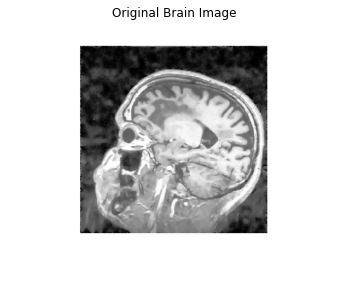

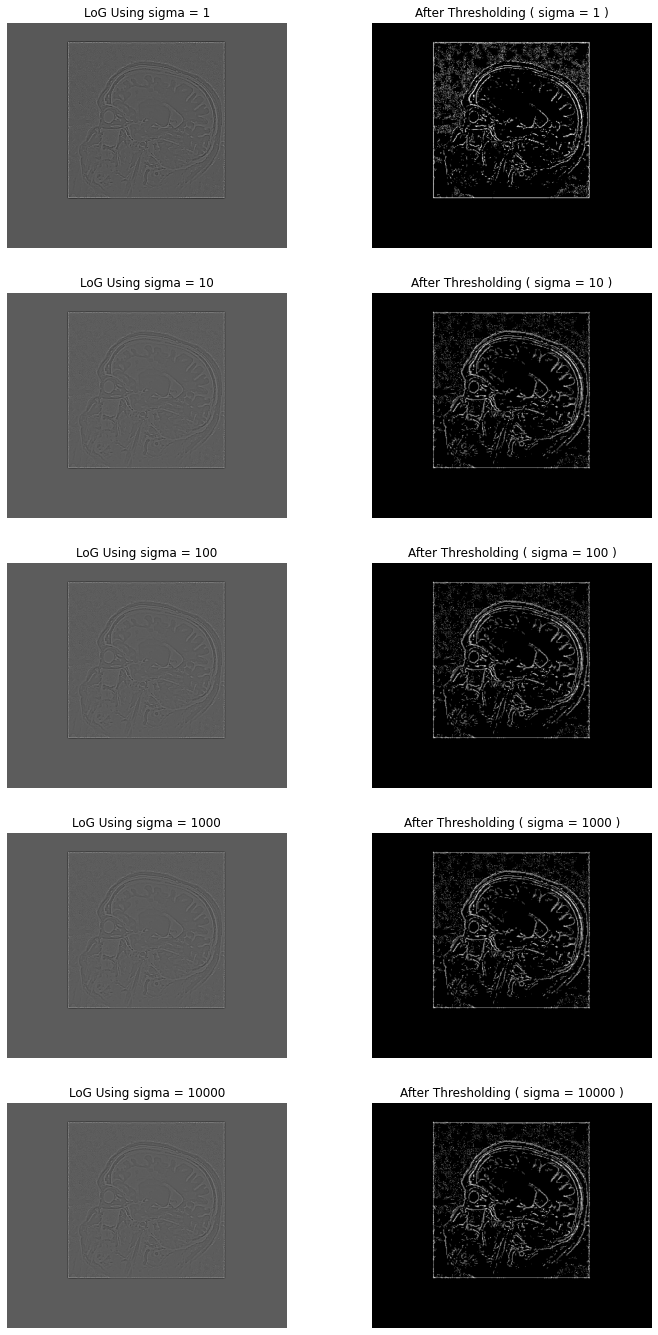

In [61]:
####################################### Brain Image ########################################

img = cv2.imread('brain.tech.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,8))
plt.imshow(img, 'gray')
plt.title('Original Brain Image')
plt.axis('off')

plt.figure(figsize=(12,24))

sigmas = [1,10,100,1000,10000]
i = 1

for sigma in sigmas:

  LoG_image, edges = LoG(img, sigma, 10)
  plt.subplot(len(sigmas),2,i)
  plt.imshow(LoG_image, 'gray')
  plt.title('LoG Using sigma = ' + str(sigma))
  plt.axis('off')

  plt.subplot(len(sigmas),2,i+1)
  plt.imshow(edges, 'gray')
  plt.title('After Thresholding ( sigma = ' +  str(sigma) + ' )')
  plt.axis('off')

  i += 2

We can see that here the results (edges) are lot better as compared to the heart image.



---



---



---



# **Question 4**
Apply histogram equalization to heart.jpg and brain.tech.jpg, and show results.

In [62]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_pdf(img):
  nrows, ncols= np.shape(img)  
  # vecimg = img
  p_r = np.zeros(256)
  for r in range(256):
    p_r[r] = np.sum(img == r)
  p_r = p_r / (nrows * ncols)
  return p_r

def Histogram_Eq(img, image_title):

  plt.axis('off')
  plt.imshow(img, cmap='gray')
  plt.title(image_title)
  plt.show()

  # Get the PDF of input image
  p_r = get_pdf(img)
  
  # Plot the PDF
  bins = np.arange(0,256)
  plt.axis('on')
  plt.bar(bins, p_r)
  plt.title('p(r) (Probability Distribution Function)')
  plt.show()

  # Get the Cumulative Distribution Function
  cdf_r = np.cumsum(p_r, dtype=float)

  # Make cdf cover the entire range from max to min
  cdf_r = (cdf_r - cdf_r.min())*255.0/(cdf_r.max() - cdf_r.min())
  cdf_r = np.ma.filled(cdf_r,0).astype('uint8')
  im_equalized = cdf_r[img]

  # Plot Histogram Equalized Image
  plt.axis('off')
  plt.imshow(im_equalized, cmap='gray')
  plt.title('Histogram-equalized image')
  plt.show()

  # Get PDF of equalized image
  p_r_equalized = get_pdf(im_equalized)

  # Plot the PDf of equalized image
  bins = np.arange(0,256)
  plt.axis('on')
  plt.bar(bins, p_r_equalized)
  plt.title('p(r) (Probability Distribution Function after equalization)')
  plt.show()

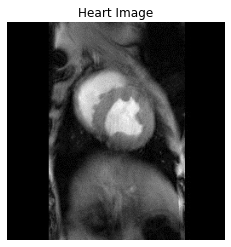

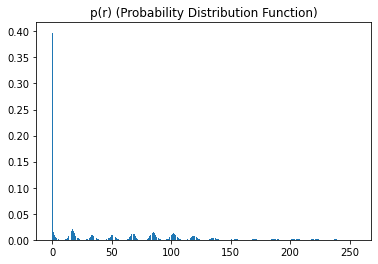

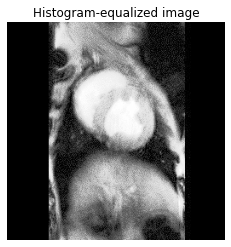

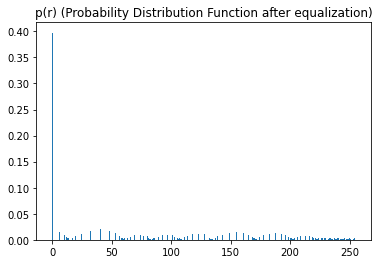

In [63]:
################################ Heart Image ################################
im = cv2.imread('heart.jpg', cv2.IMREAD_GRAYSCALE)

Histogram_Eq(im, 'Heart Image')

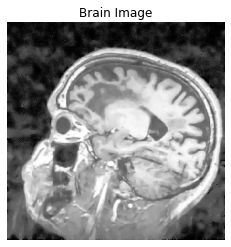

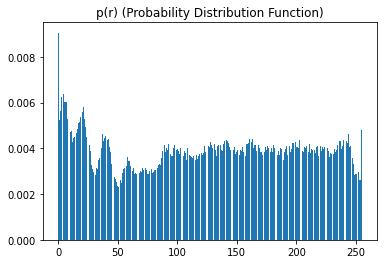

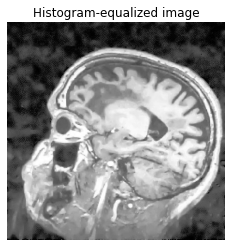

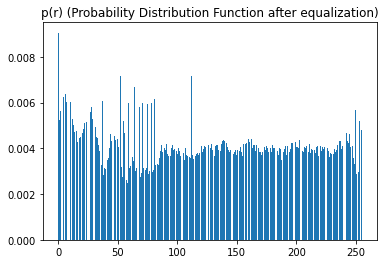

In [64]:
############################ Brain Image ############################
im = cv2.imread('brain.tech_crop.jpg', cv2.IMREAD_GRAYSCALE)
Histogram_Eq(im, 'Brain Image')



---



---



---



# **Question 5**  

Let H be a Gaussian smoothing filter. Let F be the image heart.jpg. Consider the filter  

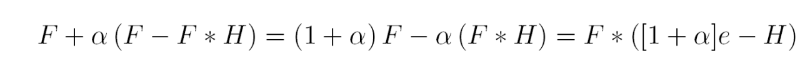

  What does this filter do? Take $α=.5$, and $σ=10$ (in the Gaussian), and apply to heart.jpg. Try a few other values of $α$ and $σ$, and show the results. The symbol e in the above formula is the delta function.

### **Answer**  
This filter is actually **sharpening** the image. Here, we are first convolving the image with a Gaussian filter ***H***. This will blur the image. The difference between the image and it's smoothened version gives the edges and details (F - F * H).  

Then this difference is added back to the original image using a weighted sum. This will enhance the edges and details giving a sharpened image.

	 	 	 	 	 alpha = 0.5 and sigma = 1


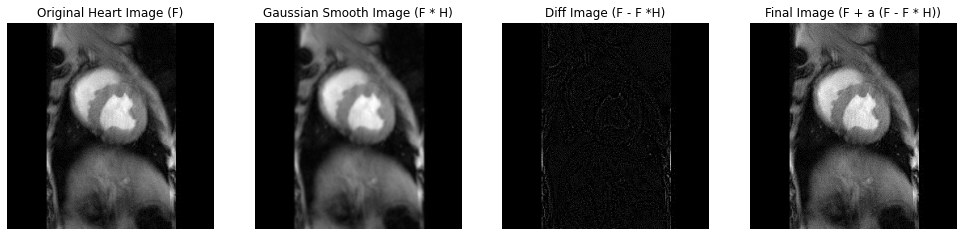




	 	 	 	 	 alpha = 0.5 and sigma = 10


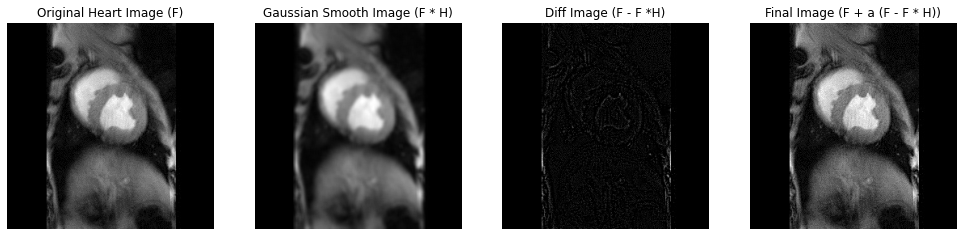




	 	 	 	 	 alpha = 0.5 and sigma = 100


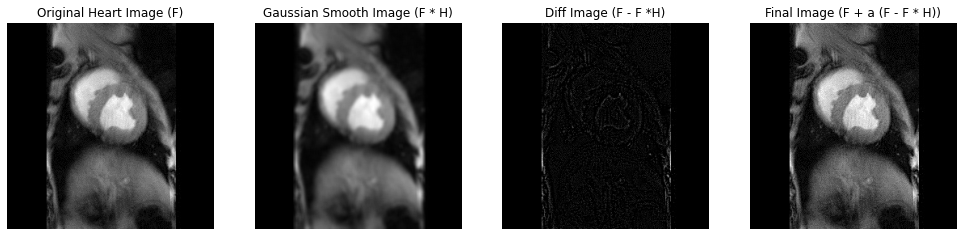




	 	 	 	 	 alpha = 0.5 and sigma = 1000


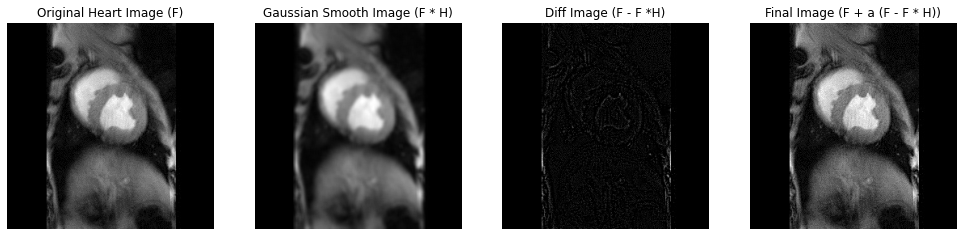




	 	 	 	 	 alpha = 0.8 and sigma = 1


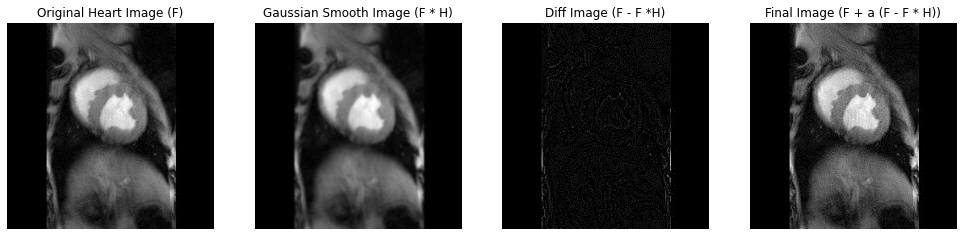




	 	 	 	 	 alpha = 0.8 and sigma = 10


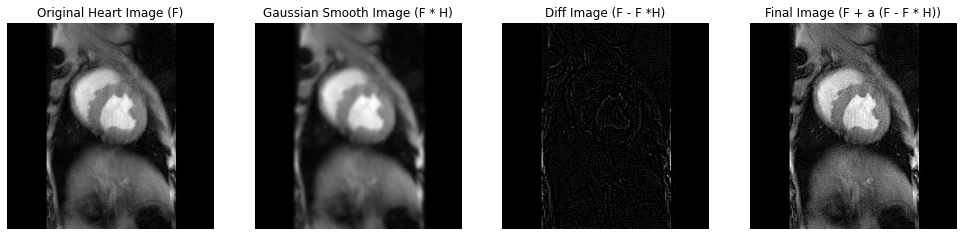




	 	 	 	 	 alpha = 0.8 and sigma = 100


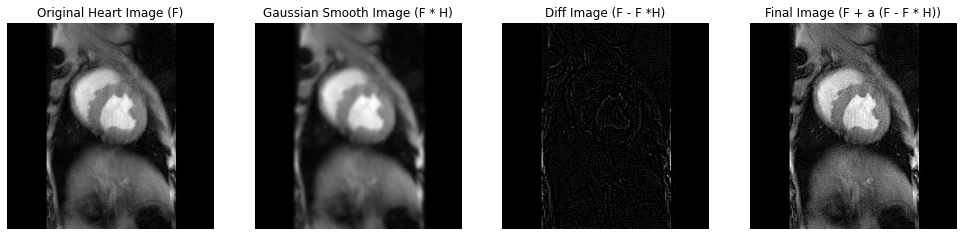




	 	 	 	 	 alpha = 0.8 and sigma = 1000


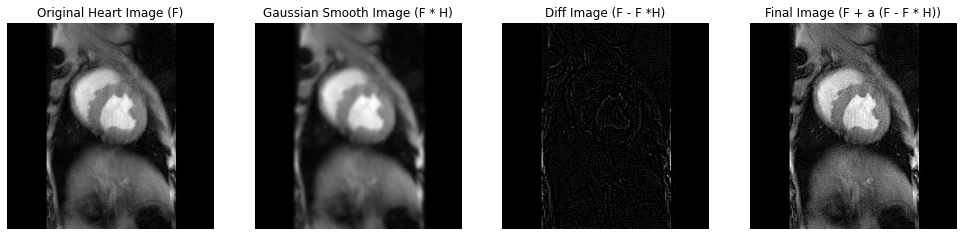




	 	 	 	 	 alpha = 1.0 and sigma = 1


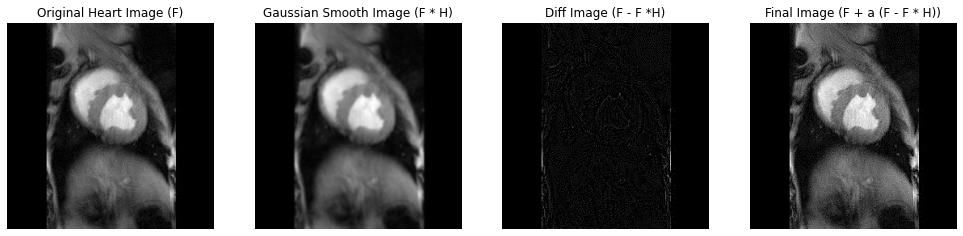




	 	 	 	 	 alpha = 1.0 and sigma = 10


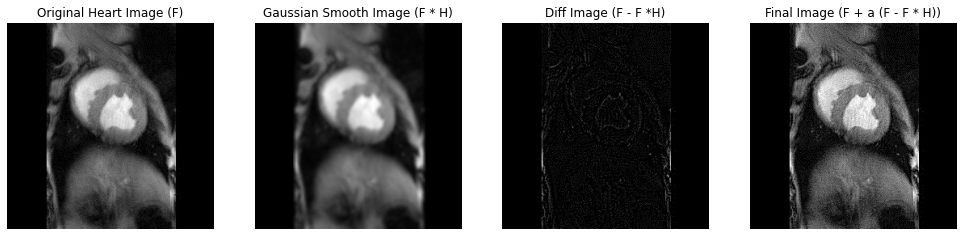




	 	 	 	 	 alpha = 1.0 and sigma = 100


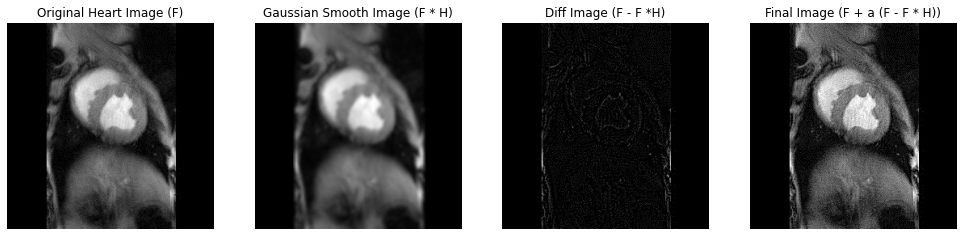




	 	 	 	 	 alpha = 1.0 and sigma = 1000


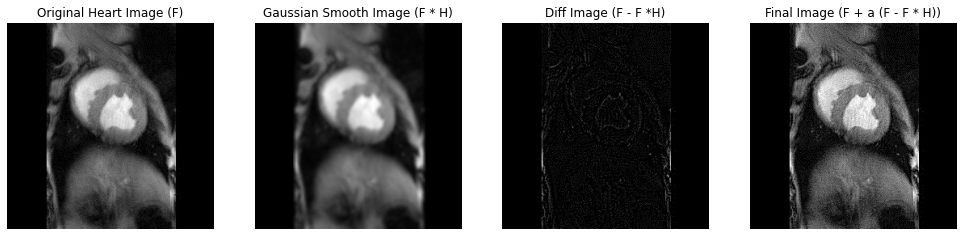




	 	 	 	 	 alpha = 1.2 and sigma = 1


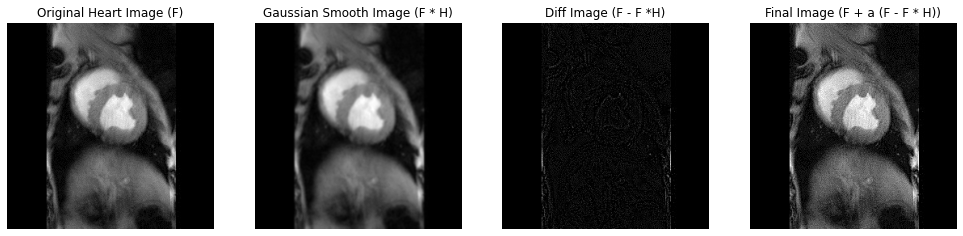




	 	 	 	 	 alpha = 1.2 and sigma = 10


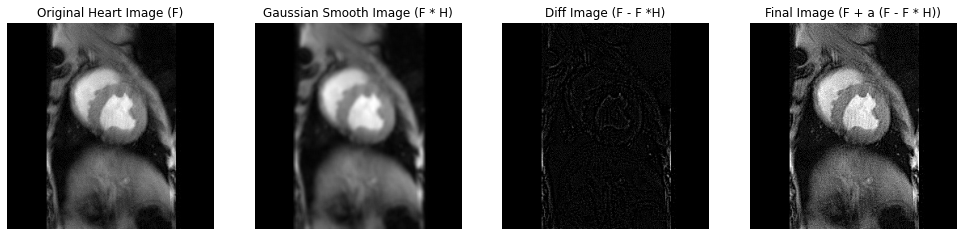




	 	 	 	 	 alpha = 1.2 and sigma = 100


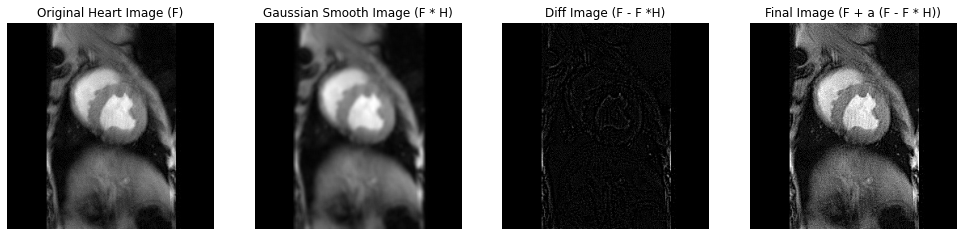




	 	 	 	 	 alpha = 1.2 and sigma = 1000


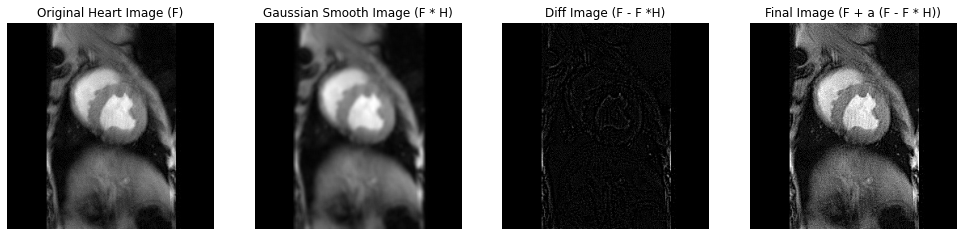

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def sharpening(img, alpha, sigma):
    print("\t \t \t \t \t alpha = {} and sigma = {}".format(alpha, sigma))
    gaussian_smooth_image = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

    plt.figure(figsize=(17,35))

    plt.subplot(1,4,1)
    plt.imshow(img, 'gray')
    plt.title("Original Heart Image (F)")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(gaussian_smooth_image, 'gray')
    plt.title("Gaussian Smooth Image (F * H)")
    plt.axis('off')

    diff_image = cv2.addWeighted(img, 1.0, gaussian_smooth_image, -1.0, 0.0)
    plt.subplot(1,4,3)
    plt.imshow(diff_image, 'gray')
    plt.title("Diff Image (F - F *H)")
    plt.axis('off')

    final_image = cv2.addWeighted(img, 1.0 + alpha, gaussian_smooth_image, -1.0 * alpha, 0)
    plt.subplot(1,4,4)
    plt.imshow(final_image, 'gray')
    plt.title("Final Image (F + a (F - F * H))")
    plt.axis('off')

    plt.show()


img = cv2.imread('heart.jpg', cv2.IMREAD_GRAYSCALE)

alpha = [0.5, 0.8, 1.0, 1.2]
sigma = [1,10,100,1000]
kernel_size = 5

for i in range(len(alpha)):
  for j in range(len(sigma)):
    sharpening(img, alpha[i], sigma[j])
    print("")
    print("")
    print("")

	 	 	 	 	 alpha = 1.4 and sigma = 1000


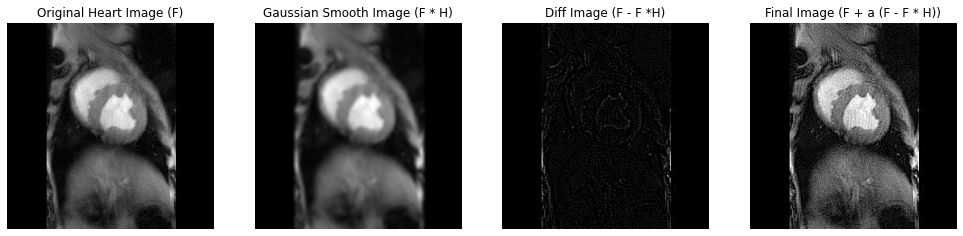

In [66]:
#### A good result ##########
sharpening(img, 1.4, 1000)